# WGAN
与demo2不同的是使用使用数据集为Patricle_100SEM，但是带标签,图片大小设置为64

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

In [2]:
# %% 超参数
dataroot = r"/home/cxmd/文档/data_for_AI_train/Particles_100SEM/"

workers = 2
n_epochs = 200          # 训练次数
batch_size = 64        # 批大小
lr = 0.00005            # 学习率
n_cpu = 8               # cpu数量
latent_dim = 100        # 隐变量维度
img_size = 64           # 图片大小
channels = 1            # 图像通道数
n_critic = 5            # 每次迭代判别器训练的次数
clip_value = 0.01       # 
sample_interval = 20   # 每400次迭代保存一次生成的图片

ngpu = 1            # 使用的GPU数量，使用0表示cpu模式

img_shape = (channels, img_size, img_size)

In [3]:
# 选择我们运行在上面的设备
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [4]:
os.makedirs(r"/home/cxmd/文档/git_files/neural_network/WGAN/run4", exist_ok=True)
os.makedirs(r"/home/cxmd/文档/git_files/neural_network/WGAN/images4", exist_ok=True)

In [5]:
# 我们可以按照设置的方式使用图像文件夹数据集。
# 创建数据集
transform = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

dataset = dset.ImageFolder(
    root=dataroot,
    transform=transform
)

# 创建加载器
data_loader = torch.utils.data.DataLoader(
    dataset=dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=workers
)

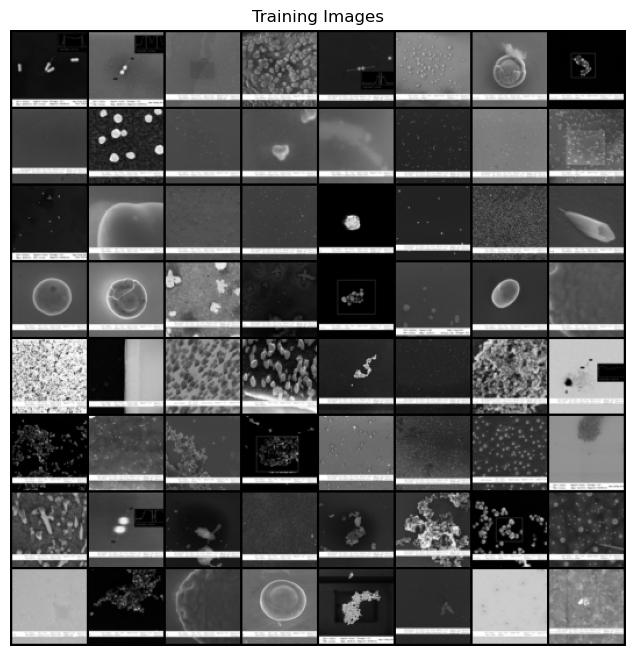

In [6]:
# 绘制部分我们的输入图像
real_batch = next(iter(data_loader))
fig, ax = plt.subplots(figsize=(8, 8))
ax.axis("off")
ax.set_title("Training Images")
ax.imshow(
    vutils.make_grid(
        real_batch[0].to(device)[:64], padding=2, normalize=True
    ).permute(1, 2, 0).cpu()
)
plt.show()

In [7]:
# 生成器
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

In [8]:
netG = Generator(ngpu).to(device)
print(netG)

# 写入tensorboard
writerG = SummaryWriter('/home/cxmd/文档/git_files/neural_network/WGAN/run4/Generator')
input_to_netG = torch.randn(batch_size, latent_dim, device=device)
writerG.add_graph(netG, input_to_model=input_to_netG)
writerG.close()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=4096, bias=True)
    (12): Tanh()
  )
)


In [9]:
# 判别器
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [10]:
netD = Discriminator(ngpu).to(device)
print(netD)

writerD = SummaryWriter('/home/cxmd/文档/git_files/neural_network/WGAN/run4/Discriminator')
input_to_netD = torch.randn(batch_size, int(np.prod(img_shape)), device=device)
writerD.add_graph(netD, input_to_netD)
writerD.close()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [11]:
# Optimizers
optimizer_G = torch.optim.RMSprop(netG.parameters(), lr=lr)
optimizer_D = torch.optim.RMSprop(netD.parameters(), lr=lr)

In [12]:
batches_done = 0
writer = SummaryWriter('/home/cxmd/文档/git_files/neural_network/WGAN/run4/')

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(data_loader):
        
        # 设置输入
        real_imgs = imgs.to(device)
        
        # ------------------
        #  训练 判别器
        # ------------------
        
        optimizer_D.zero_grad()
        
        # 对噪声采样
        z = torch.randn(imgs.shape[0], latent_dim, device=device)
        
        # 生成器产生一批假图片
        fake_imgs = netG(z).to(device)
        
        real_validity = netD(real_imgs)
        fake_validity = netD(fake_imgs)
        
        # 判别器损失
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity)
        d_loss.backward()
        optimizer_D.step()
        
        
        # 遍历判别器的所有参数
        for p in netD.parameters():
            # 使用clamp_()函数将每个参数的值限制在[-opt.clip_value, opt.clip_value]的范围内
            # 这是Wasserstein GAN（WGAN）的一个关键步骤，称为权重裁剪（Weight Clipping）
            # 这一步是为了满足WGAN的一个重要假设：判别器（或者叫做critic）是一个1-Lipschitz函数
            # Lipschitz条件是WGAN理论保证收敛的关键
            # 注意：clamp_()是一个原地操作（in-place operation），意味着它会直接修改参数的值，而不会返回一个新的张量
            p.data.clamp_(-clip_value, clip_value)
        
        # ------------------
        #  训练 生成器
        # ------------------
        
        if i % n_critic == 0:
            
            optimizer_G.zero_grad()
        
            gen_imgs = netG(z)
            
            gen_validity = netD(gen_imgs)
            
            # 生成器损失
            g_loss = -torch.mean(gen_validity)
            
            g_loss.backward()
            optimizer_G.step()
            
            # tensorboard跟踪数据
            writer.add_scalar('loss_d', d_loss.item(), epoch*len(data_loader)+i)
            writer.add_scalar('loss_g', g_loss.item(), epoch*len(data_loader)+i)
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, n_epochs, i, len(data_loader), d_loss.item(), g_loss.item())
            )
            
            if batches_done % sample_interval == 0:
                # writer image to tensorboard
                imgs_to_tensorboard = gen_imgs.data[:25]
                imgs_to_tensorboard = vutils.make_grid(imgs_to_tensorboard, nrow=5, normalize=True).cpu()
                writer.add_image("fake_imgs", imgs_to_tensorboard, epoch*len(data_loader)+i)
                
                save_image(fake_imgs.data[:25], r"/home/cxmd/文档/git_files/neural_network/WGAN/images4/%d.png" % batches_done, nrow=5, normalize=True)

            batches_done += n_critic

writer.close()

[Epoch 0/200] [Batch 0/62] [D loss: 0.063525] [G loss: -0.009831]
[Epoch 0/200] [Batch 5/62] [D loss: -0.700630] [G loss: -0.017207]
[Epoch 0/200] [Batch 10/62] [D loss: -2.078245] [G loss: -0.068669]
[Epoch 0/200] [Batch 15/62] [D loss: -3.012743] [G loss: -0.193964]
[Epoch 0/200] [Batch 20/62] [D loss: -5.880758] [G loss: -0.418806]
[Epoch 0/200] [Batch 25/62] [D loss: -7.311215] [G loss: -0.738202]
[Epoch 0/200] [Batch 30/62] [D loss: -9.894303] [G loss: -1.163213]
[Epoch 0/200] [Batch 35/62] [D loss: -11.015931] [G loss: -1.744500]
[Epoch 0/200] [Batch 40/62] [D loss: -10.706346] [G loss: -2.352508]
[Epoch 0/200] [Batch 45/62] [D loss: -14.359747] [G loss: -3.141535]
[Epoch 0/200] [Batch 50/62] [D loss: -16.169144] [G loss: -4.087131]
[Epoch 0/200] [Batch 55/62] [D loss: -17.953093] [G loss: -5.196488]
[Epoch 0/200] [Batch 60/62] [D loss: -16.868753] [G loss: -6.227708]


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256])